In [1]:
import numpy as np
import scipy.sparse as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import cm

# ADI Method Implementation

In [2]:
# This is the implementation of the ADI method in two dimensions

def adi_2d_with_wind(x_steps, y_steps, t_steps, x_start, x_end, y_start, y_end, t_start, T, u_t0, u_x0, u_xL, u_y0, u_yL, v, w, alpha):
    
    # initialize some variables
    del_x = (x_end - x_start) / (x_steps-1)
    del_y = (y_end - y_start) / (y_steps-1)
    del_t = (T - t_start) / (t_steps-1)
    
    Us = []

    # define the derivative and second derivative matrices
    def get_D2(r, shape):
        return sp.diags([r, -2*r, r], [-1, 0, 1], shape=shape)

    def get_D(del_, shape):
        return sp.diags([-del_t/(4*del_),del_t/(4*del_)], [-1, 1], shape=shape)
    
    
    x = np.linspace(x_start, x_end, x_steps)
    y = np.linspace(y_start, y_end, y_steps)
    
    U = u_t0

    U[0, :] = u_x0
    U[-1, :] = u_xL
    U[:, 0] = u_y0
    U[:, -1] = u_yL

    rx = alpha * del_t / del_x**2
    ry = alpha * del_t / del_y**2

    D_x2 = get_D2(rx/2, (x_steps, x_steps))
    D_y2 = get_D2(ry/2, (y_steps, y_steps))

    D_x = get_D(del_x, (x_steps, x_steps))
    D_y = get_D(del_y, (y_steps, y_steps))


    # returns the advection matrix for x at fixed y[j]
    def get_adv_x(j):
        v1 = v(x, y[j])[1:]
        v2 = -v(x, y[j])[:-1]

        return (np.diag(v1, k =1) + np.diag(v2, k=-1)) * (del_t/ (4*del_x))

    # returns the advection matrix for y at fixed x[i]
    def get_adv_y(i):
        w1 = w(x[i], y)[:-1]
        w2 = -w(x[i], y)[1:]

        return (np.diag(w1, k =1) + np.diag(w2, k=-1)) * (del_t/ (4*del_y))

    # wind matrix in the x-direciton
    def get_w(size):
        W = np.zeros(size)
        for i in range(x_steps):
            for j in range(y_steps):
                W[i,j] = w(x[i], y[j])
        return W

    # wind matrix in the y-direction
    def get_v(size):
        V = np.zeros(size)
        for i in range(x_steps):
            for j in range(y_steps):
                V[i,j] = v(x[i], y[j])
        return V

    
    # the algorithm!
    for t in range(t_steps):
        
        # predictor step
        U_pred = np.zeros((x_steps, y_steps))
        for j in range(y_steps):
            col = U[:, j]
            adv_x = get_adv_x(j)
            A =  sp.identity(x_steps) - D_x2 + adv_x
            W = get_w((y_steps, y_steps))
            
            B = (sp.identity(y_steps) + D_y2 - (W*D_y)) @ col

            predict = sp.linalg.spsolve(A, B.T)

            U_pred[:, j] = predict

        # corrector step 
        U_correct = np.zeros((x_steps, y_steps))
        for i in range(x_steps):
            row = U_pred[i, :]
            adv_y = get_adv_y(i)
            A = sp.identity(y_steps) - D_y2 + adv_y
            V = get_v((x_steps, x_steps))


            B = (sp.identity(x_steps) + D_x2 - (V*D_x)) @ row
            correct = sp.linalg.spsolve(A, B.T)
            U_correct[i, :] = correct
        
        # iterate
        Us.append(U)
        U = U_correct


    return U, Us


# Example Usage

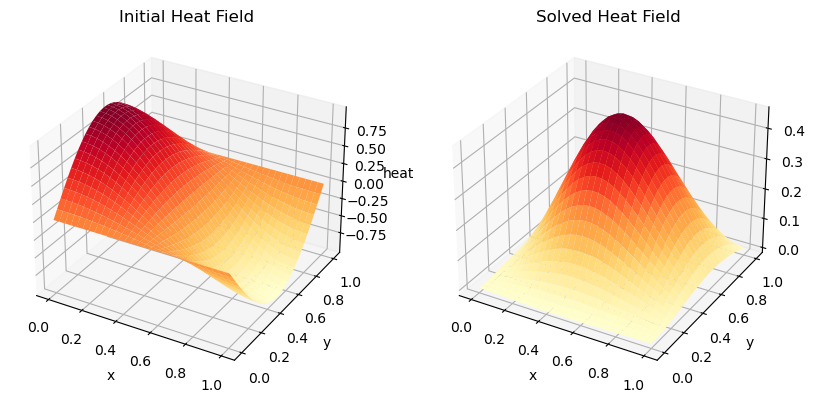

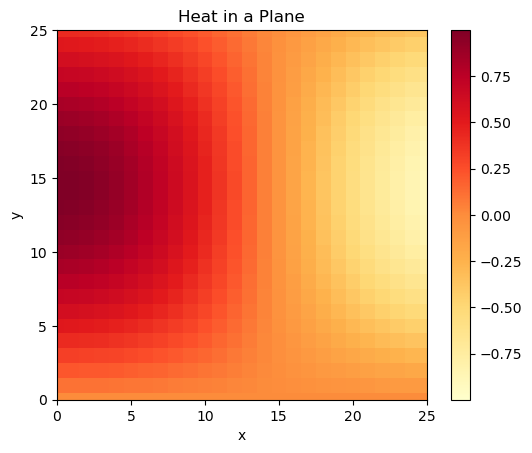

In [4]:
# define all our variables
x_steps = 30
y_steps = 30
t_steps = 30
x_start = 0
x_end = 1
y_start = 0
y_end = 1
t_start = 0
T = 0.1

u_t0 = np.zeros((x_steps, y_steps))

x = np.linspace(x_start, x_end, x_steps)
y = np.linspace(y_start, y_end, y_steps)


# example functions to use
f = lambda x,y: np.sin(x*np.pi) * np.cos(y*np.pi)

#f = lambda x,y: np.sin(x*np.pi)/2

#f = lambda x,y: np.exp(-(x-0.5)**2 * (y-0.5)**2)
#f = lambda x, y: np.sin(x* np.pi)/2 + np.cos(y * 2* np.pi)/2
#f = lambda x,y: np.sin(x * np.pi)/2 + np.sin(y)

for i in range(len(x)):
    for j in range(len(y)):
        u_t0[i,j] = f(x[i], y[j])

u_x0 = f(x_start,y)
u_xL = f(x_end, y)
u_y0 = f(x, y_start)
u_yL = f(x, y_end)

# v is the function for wind velocity in the x direction
v = lambda x,y : 3+ x*0 + y*0

# w is the function for wind velocity in the y direction
w = lambda x,y : 4 + x*0 + y*0


alpha = 0.3
fig = plt.figure(figsize=(10,8))
x, y = np.meshgrid(np.linspace(x_start, x_end, x_steps), np.linspace(y_start,y_end,y_steps))

init = fig.add_subplot(121, projection='3d')
init.plot_surface(x,y,u_t0, cmap=cm.YlOrRd)
init.set_title('Initial Heat Field')
init.set_xlabel('x')
init.set_ylabel('y')
# init.set_zlim(-0.5,0.5)
init.set_zlabel('heat')


ax = fig.add_subplot(122, projection='3d')
U_T, Us = adi_2d_with_wind(x_steps, y_steps, t_steps, x_start, x_end, y_start, y_end, t_start, T, u_t0, u_x0, u_xL, u_y0, u_yL, v, w, alpha)

# Plot the surface.
surf = ax.plot_surface(x, y, U_T, cmap=cm.YlOrRd)
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlim(-0.5,0.5)
ax.set_title('Solved Heat Field')

plt.show()

plt.imshow(u_t0, cmap=cm.YlOrRd)
plt.title('Heat in a Plane')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.xlim(0,25)
plt.ylim(0,25)
plt.show()

# Animate the output

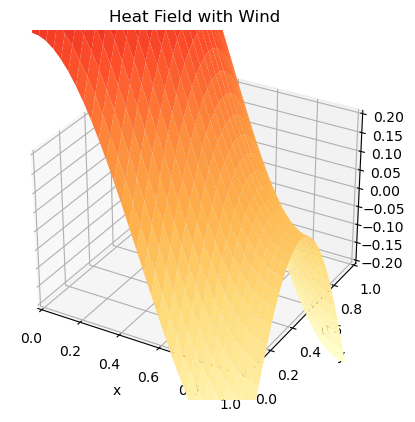

In [29]:
# function to animate the output (in 3 dimensions) of a run of the ADI method 
def animate():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Initialize meshgrid
    x = np.linspace(x_start, x_end, x_steps)
    y = np.linspace(y_start, y_end, y_steps)
    X, Y = np.meshgrid(x, y)
    del_t = (T-t_start)/t_steps

    U_t,Us = adi_2d_with_wind(x_steps, y_steps, t_steps, x_start, x_end, y_start, y_end, t_start, T, u_t0, u_x0, u_xL, u_y0, u_yL, v, w, alpha)
    def update(i):
        ax.clear() 
        
        #set limits and labels here because we just cleared the plot
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(-.2,.2)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Heat Field with Wind')
        
        #plot
        return ax.plot_surface(X, Y, Us[i], cmap=cm.YlOrRd)
    

    ani = animation.FuncAnimation(fig, update, frames=range(t_steps), interval=250)
    ani.save('wildfirewithwind1.gif')

animate()




/Users/janehousley/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


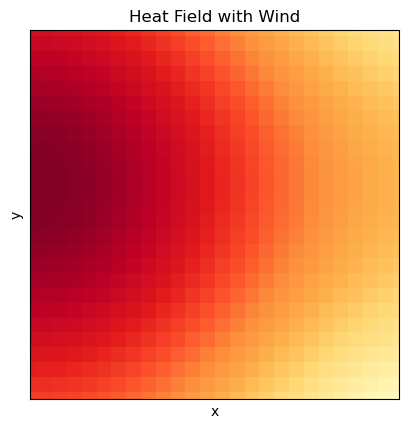

In [30]:
# function to animate the output (in 2 dimensions) of the output of a run of the ADI method
def animate_above():
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Initialize meshgrid
    x = np.linspace(x_start, x_end, x_steps)
    y = np.linspace(y_start, y_end, y_steps)
    X, Y = np.meshgrid(x, y)
    del_t = (T-t_start)/t_steps

    U_t,Us = adi_2d_with_wind(x_steps, y_steps, t_steps, x_start, x_end, y_start, y_end, t_start, T, u_t0, u_x0, u_xL, u_y0, u_yL, v, w, alpha)
    def update(i):
        ax.clear() 
        
        #set limits and labels here because we just cleared the plot
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0,25)
        ax.set_ylim(0,25)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Heat Field with Wind')
        
        #plot
        return ax.imshow(Us[i], cmap=cm.YlOrRd)
    

    ani = animation.FuncAnimation(fig, update, frames=range(t_steps), interval=250)
    ani.save('wildfirewithwindabove1.gif')

animate_above()